In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.optim as optim
import torch.nn as nn

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer

/home/parallels/.pyenv/versions/3.10.2/envs/spotify_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # --------- MODEL CREATION ---------
# class BertRegressor(nn.Module):
#     '''Addition of a multi-output regression layer to BERT model.'''
#     def __init__(self, drop_rate=0.2):
#         ''' Definition of BERT model and regression model '''
#         super().__init__()
#         dim_in, dim_out = 768, 24
#         self.model = BertModel.from_pretrained('bert-base-cased')

#         self.regressor = nn.Sequential(
#             nn.Dropout(drop_rate),
#             nn.Linear(dim_in, dim_out)
#             # nn.Linear(dim_in, 2000),
#             # nn.ReLU(),
#             # nn.Linear(2000, dim_out)
#         )
#         self.double()


#     def freeze_bert(self, num_layers):
#         # num_layers should be within [0, 12]
#         layers = [self.model.embeddings, *self.model.encoder.layer[:num_layers]]
#         for layer in layers:
#             # print(module)
#             for param in layer.parameters():
#                 param.requires_grad = False


#     def forward(self, input_ids, attention_masks):
#         ''' Connecting output of BERT to regression layer '''
#         bert_out = self.model(input_ids, attention_masks)
#         cls_outputs = bert_out[1]
#         regression_out = self.regressor(cls_outputs)
#         return regression_out


# model = BertRegressor(drop_rate=0.2)
# # model.freeze_bert(1)

In [3]:
# For Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# --------- MODEL CREATION ---------
class BertRegressor(nn.Module):
    '''Addition of a multi-output regression layer to BERT model.'''
    def __init__(self): #, drop_rate=0.2):
        ''' Definition of BERT model and regression model '''
        super().__init__()
        dim_in, dim_out = 768, 1
        self.model = BertModel.from_pretrained('bert-base-cased')

        # self.regressor = nn.Sequential(
        #     # nn.Dropout(drop_rate),
        #     nn.Linear(dim_in, dim_out)
        #     # nn.Linear(dim_in, 2000),
        #     # nn.ReLU(),
        #     # nn.Linear(2000, dim_out)
        # )
        self.regressor = nn.Linear(dim_in, dim_out)
        self.double()


    # def freeze_bert(self, num_layers):
    #     # num_layers should be within [0, 12]
    #     layers = [self.model.embeddings, *self.model.encoder.layer[:num_layers]]
    #     for layer in layers:
    #         # print(module)
    #         for param in layer.parameters():
    #             param.requires_grad = False


    def forward(self, input_ids, attention_masks):
        ''' Connecting output of BERT to regression layer '''
        bert_out = self.model(input_ids, attention_masks)
        cls_outputs = bert_out[1]
        # a_func = nn.ReLU()
        regression_out = self.regressor(cls_outputs)
        return regression_out


model = BertRegressor()  #drop_rate=0.2)
# model.freeze_bert(1)

NameError: name 'nn' is not defined

In [5]:
class TitleDataset(Dataset):
    def __init__(self, titles, labels, tokenizer, max_length):
        self.titles = titles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length


    def __getitem__(self, idx):        
        tokenized_input = self.tokenizer(text=self.titles[idx],
                                add_special_tokens=True,
                                padding='max_length',
                                max_length=self.max_length,
                                return_tensors='pt',  # PyTorch tensors
                                return_attention_mask=True)

        result = {
            'input_ids': tokenized_input['input_ids'].squeeze(),
            'attention_mask': tokenized_input['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx])
        }

        return result


    def __len__(self):
        return len(self.titles)


In [6]:
# ---------------  DATASET ----------------
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

db_file = "../../data/title_dataset-PREVIEW.db"
# Google Colab:
# db_file = "/content/drive/My Drive/Colab Notebooks/Title2Playlist/title_dataset-PREVIEW.db"
sql_conn = sqlite3.Connection(db_file)

# All data
data = pd.read_sql(
    "SELECT * FROM titles",
    sql_conn
)

In [7]:
# --------------- TOKENIZATION -------------

standard_scaler = StandardScaler()

# Data from dataset
n = 100 
train_titles = data.iloc[:n, 0].to_numpy()
features = np.reshape(data.iloc[:n, 1].to_numpy(), (n, -1))
standard_scaler.fit(features)
train_labels = standard_scaler.transform(features).squeeze()
# train_data.head(20)

# print(max(train_titles, key=lambda x: len(x.split())))
# Find most amount of words from all titles
max_words = len(max(train_titles, key=lambda x: len(x.split())).split())
# Using double max words as max sequence length (arbitrary choice)
max_seq_length = max_words * 2

train_dataset = TitleDataset(train_titles, train_labels, tokenizer, max_seq_length)

# tokenized_input = tokenizer(text=train_titles.tolist(),
#                             add_special_tokens=True,
#                             padding='longest',
#                             return_attention_mask=True)
                        

# Creation of TensorDataset
# train_inputs = torch.tensor(tokenized_input['input_ids'])
# train_masks = torch.tensor(tokenized_input['attention_mask'])
# train_labels = torch.tensor(train_labels)
# train_dataset = TensorDataset(train_inputs, train_masks, train_labels)


In [ ]:
# -------------------- TRAINING --------------------

batch_size = 25
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)
model.to(device)

loss_fn = nn.MSELoss()
# this learning rate was used in original BERT paper
optimizer = optim.SGD(model.parameters(), lr=5e-5)

loss_log = []
epochs = 10
model.train()
# model.zero_grad()

for epoch in range(epochs):
    print(f"-------- EPOCH {epoch} --------")
    for step, batch in enumerate(train_dataloader):
        print(f"BATCH {step}")
        inputs, masks, labels = tuple(row.to(device) for row in batch.values())
        optimizer.zero_grad()
        outputs = model(inputs, masks)
        loss = loss_fn(outputs.squeeze(), labels.squeeze())
        print(f"Loss = {loss.item()}")
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()


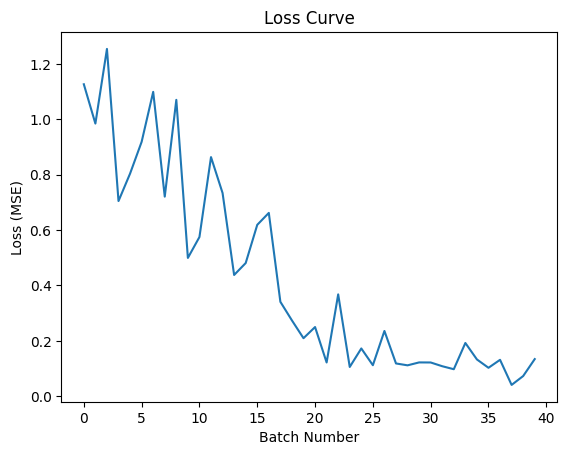

In [ ]:
# ------------ PLOTS ---------------

plt.plot(range(len(loss_log)), loss_log)
plt.title("Loss Curve")
plt.xlabel("Batch Number")
plt.ylabel("Loss (MSE)")
plt.show()
